# This script is used to find all the URLs from the CVE JSON files
# Scanning CVEs for git-based commit URLs

In [2]:
from tabulate import tabulate
from pathlib import Path
import os
import pandas as pd
import glob
import re
import json
import git
import pandas as pd
from urllib.parse import urlparse
from warnings import simplefilter

simplefilter(action="ignore", category=pd.errors.PerformanceWarning)


# Trying incremental approach

In [6]:
def clone_or_pull(repo_url, repo_path):
    """Clone the repo if it doesn't exist, or pull if it does."""
    modified_files = []
    print(f"Cloning or pulling {repo_url} to {repo_path}")
    if os.path.exists(repo_path):
        # repo exists, perform a git pull
        try:
            repo = git.Repo(repo_path)
            origin = repo.remotes.origin
            # Store the current commit before pulling
            current_commit = repo.head.commit
            origin.pull()
            print("Git pull successful")
            # Compare current commit with the latest one after pull
            for item in repo.head.commit.diff(current_commit):
                modified_files.append(item.a_path)
        except git.exc.GitCommandError as e:
            print("Error occurred during git pull:", e)
    else:
        # repo doesn't exist, perform a git clone
        try:
            git.Repo.clone_from(repo_url, repo_path)
            print("Git clone successful")
        except git.exc.GitCommandError as e:
            print("Error occurred during git clone:", e)
    return modified_files


def get_modified_cve_files(modified_files, data_dir):
    """Find the modified CVE JSON files after a git pull"""
    if modified_files:
        print(f"Modified files after git pull: {modified_files}")
        modified_cve_files = [Path(data_dir, 'cvelistV5', file) for file in modified_files if file.endswith(".json") and "CVE" in file]
        print("Modified files related to CVE:", modified_cve_files)
        print("#files new/updated of CVE records:", len(modified_cve_files))
    else:
        print("No modified files found")
        modified_cve_files = []
    return modified_cve_files


repo_url = "https://github.com/CVEProject/cvelistV5.git"
data_dir = "/Users/guru/research/FixMe/data/"
cve_repo_path = data_dir + Path(repo_url).stem

# Call the clone_or_pull function with the repo URL and path
modified_files = clone_or_pull(repo_url, cve_repo_path)

if modified_files:
    # Get the modified CVE JSON files
    modified_cve_files = get_modified_cve_files(modified_files, data_dir)
    modified_cve_files[:5]

Cloning or pulling https://github.com/CVEProject/cvelistV5.git to /Users/guru/research/FixMe/data/cvelistV5
Git pull successful
No modified files found


[]

In [43]:
modified_cve_files

[]

In [46]:
import sqlite3

conn = sqlite3.connect(data_dir + "Fixme.db")

def get_refs_from_db(conn):
    refs = pd.read_sql_query("SELECT * FROM cve;", conn).references
    refs = list(refs.apply(eval).explode())
    return refs
    
get_refs_from_db(conn)

['https://github.com/mastodon/mastodon/security/advisories/GHSA-7w3c-p9j8-mq3x',
 'https://github.com/mastodon/mastodon/commit/68eaa804c9bafdc5f798e114e9ba00161425dd71',
 'https://github.com/mastodon/mastodon/security/advisories/GHSA-jhrq-qvrm-qr36',
 'https://github.com/mastodon/mastodon/commit/9fee5e852669e26f970e278021302e1a203fc022',
 'https://github.com/MISP/MISP/commit/312d2d5422235235ddd211dcb6bb5bb09c07791f',
 'https://github.com/MISP/MISP/compare/v2.4.183...v2.4.184',
 'https://salsa.debian.org/reproducible-builds/diffoscope/-/issues/361',
 'https://salsa.debian.org/reproducible-builds/diffoscope/-/commit/dfed769904c27d66a14a5903823d9c8c5aae860e',
 'https://lists.fedoraproject.org/archives/list/package-announce%40lists.fedoraproject.org/message/OUNBANAWD6TZH2NRRV4YUIAXEHLUJQ47/',
 'https://github.com/dompdf/php-svg-lib/security/advisories/GHSA-f3qr-qr4x-j273',
 'https://github.com/dompdf/php-svg-lib/commit/732faa9fb4309221e2bd9b2fda5de44f947133aa',
 'https://github.com/dompdf/

In [39]:

cves = list(df.cveId)

In [212]:
from pathlib import Path

ref_files = list(patch_links.keys())

if json_files and ref_files:
    print(f"Total JSON files: {len(json_files)}")
    print(f"Total reference files: {len(ref_files)}\n")
    total_cves = [Path(x).stem for x in json_files]
    total_cves = [file for file in total_cves if file.startswith("CVE-")]
    print(f"Total CVEs: {len(total_cves)}")

    ref_cves = [Path(x).stem for x in ref_files]
    ref_cves = [file for file in ref_cves if file.startswith("CVE-")]
    print(f"Total CVEs with references: {len(ref_cves)}")
else:
    print("No JSON file found in the directory.")

Total JSON files: 240030
Total reference files: 17373

Total CVEs: 240028
Total CVEs with references: 17373


# Plotting of original CVEs and those included FixMe

In [219]:
years_cve_total = [file.split('-')[1] for file in total_cves]
years_cve_ref = [file.split('-')[1] for file in ref_cves]

freq_total = pd.Series(years_cve_total).value_counts().sort_index()
freq_ref = pd.Series(years_cve_ref).value_counts().sort_index()
# Get unique years from both Series
all_years = sorted(set(freq_total.index) | set(freq_ref.index))

# Reindex both Series with all years and fill NaN (missing values) with 0
freq_total= freq_total.reindex(all_years, fill_value=0)
freq_ref = freq_ref.reindex(all_years, fill_value=0)

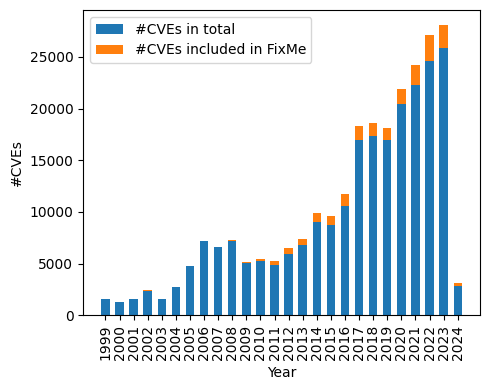

In [365]:
fig, ax = plt.subplots(figsize=(5, 4))
bar_width = 0.6
# index = range(len(freq_total))

bar1 = ax.bar(freq_total.index, freq_total.values, bar_width, label='#CVEs in total')
bar2 = ax.bar(freq_ref.index, freq_ref.values, bar_width, label='#CVEs included in FixMe', bottom=freq_total.values)

# Adding labels, title, and legend
ax.set_xlabel('Year')
ax.set_ylabel('#CVEs')
ax.set_xticks(index)
ax.set_xticklabels(freq_total.index, rotation=90)
ax.legend()
plt.tight_layout()
plt.savefig('figure/cve_yearly_bar.png', bbox_inches='tight', dpi=300)
plt.show()

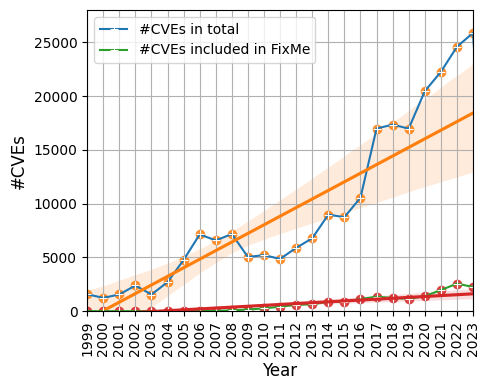

In [366]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# freq_total = pd.Series(years_cve_total).value_counts().sort_index()

df = pd.DataFrame({'year': freq_total.index.astype(int), 'count': freq_total.values.astype(int)})
df['count2'] = freq_ref.values.astype(int)

df.index = df['year']
df.rename(columns={'count': '#CVEs in total', 'count2': '#CVEs included in FixMe'}, inplace=True)

plt.figure(figsize=(5, 4))

for column in df.columns:
    if column != 'year':
        sns.lineplot(x=df.index, y=df[column], marker='+', linestyle='-', label=column)
        # sns.barplot(x=df.index, y=df[column], alpha=0.2, label=column)
        sns.regplot(x=df.index, y=df[column], scatter=True)

plt.xlabel('Year', fontsize=12)
plt.ylabel('#CVEs', fontsize=12)
# plt.title('Trend of CVEs Each Year')
plt.xticks(df.year, rotation=90)  
plt.xlim(1999, 2023)  
plt.ylim(0, 28000)
plt.grid() 
plt.legend(loc='upper left', fontsize=10)  
plt.tight_layout()
plt.savefig('figure/cve_yearly_line.png', bbox_inches='tight', dpi=300)
plt.show()

# Semantic scholar API to search research papers/datasets

In [ ]:
import requests

api_key = "ATTZX7wvDw8aQ2A3Xmjff8sS0O0UMhqk8Zn3jxCS"


# Define the API endpoint URL
url = 'https://api.semanticscholar.org/graph/v1/paper/search'

# More specific query parameter
query_params = {'query': 'Measurement of Power for DOS attacks', 'limit': 5}

# Define headers with API key
headers = {'x-api-key': api_key}

# Send the API request
response = requests.get(url, params=query_params, headers=headers)

# Check response status
if response.status_code == 200:
   response_data = response.json()
   # Process and print the response data as needed
   print(response_data)
else:
   print(f"Request failed with status code {response.status_code}: {response.text}")
response_data

# CSV CVE processing

In [2]:
import pandas as pd 

csv = '/Users/guru/research/FixMe/data/cve.csv'
df = pd.read_csv(csv)
df

/var/folders/p_/9ryggq9s67zbhxhzlms6wmzw0000gn/T/ipykernel_71690/2925404587.py:4: DtypeWarning: Columns (3,7,27,30,31,34,38,44,45,64,65,66,67,68,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,90,91,92,93,94,95,96,97,98,100,101,102,103,104,105,106,108,109,110,111,112,113,114,115) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csv)


,affected,assignerOrgId,assignerShortName,configurations,credits,cveId,cvssV2_0_baseScore,cvssV2_0_vectorString,cvssV2_0_version,cvssV3_0_attackComplexity,...,x_legacyV4Record_impact_cvss_vectorString,x_legacyV4Record_impact_cvss_version,x_legacyV4Record_problemtype_problemtype_data,x_legacyV4Record_references_reference_data,x_legacyV4Record_solution,x_legacyV4Record_source_advisory,x_legacyV4Record_source_defect,x_legacyV4Record_source_discovery,x_legacyV4Record_work_around,x_redhatCweChain
0,[{'collectionURL': 'https://git.eclipse.org/c/...,e51fbebd-6053-4e49-959f-1b94eeb69a2c,eclipse,NaN,"[{'lang': 'en', 'type': 'finder', 'user': '000...",CVE-2023-4759,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,"[{'collectionURL': 'https://git.kernel.org/', ...",14ed7db2-1595-443d-9d34-6215bf890778,Google,NaN,NaN,CVE-2023-1998,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,[{'collectionURL': 'https://git.launchpad.net/...,cc1ad9ee-3454-478d-9317-d3e869d708bc,canonical,NaN,"[{'lang': 'en', 'type': 'finder', 'value': 'Je...",CVE-2023-2612,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,[{'collectionURL': 'https://gitee.com/src-open...,7e1ac599-2767-43fa-b3ea-f10178cc98f2,openEuler,NaN,NaN,CVE-2021-33631,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,[{'collectionURL': 'https://gitee.com/src-open...,7e1ac599-2767-43fa-b3ea-f10178cc98f2,openEuler,NaN,NaN,CVE-2021-33630,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17421,"[{'vendor': 'zulip', 'product': 'zulip', 'vers...",a0819718-46f1-4df5-94e2-005712e83aaa,GitHub_M,NaN,NaN,CVE-2022-41914,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17422,"[{'vendor': 'zulip', 'product': 'zulip', 'vers...",a0819718-46f1-4df5-94e2-005712e83aaa,GitHub_M,NaN,NaN,CVE-2023-33186,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17423,"[{'vendor': 'zwczou', 'product': 'WeChat SDK P...",1af790b2-7ee1-4545-860a-a788eba489b5,VulDB,NaN,"[{'lang': 'en', 'value': 'VulDB GitHub Commit ...",CVE-2018-25082,6.5,AV:N/AC:L/Au:S/C:P/I:P/A:P,2.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17424,"[{'vendor': 'zxcvbn-ts', 'product': 'zxcvbn', ...",a0819718-46f1-4df5-94e2-005712e83aaa,GitHub_M,NaN,NaN,CVE-2023-34109,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
len([x for x in df.columns if 'x_legacy' in x])

43

In [9]:
print(df.columns)   

Index(['affected', 'assignerOrgId', 'assignerShortName', 'configurations',
       'credits', 'cveId', 'cvssV2_0_baseScore', 'cvssV2_0_vectorString',
       'cvssV2_0_version', 'cvssV3_0_attackComplexity',
       ...
       'x_legacyV4Record_impact_cvss_vectorString',
       'x_legacyV4Record_impact_cvss_version',
       'x_legacyV4Record_problemtype_problemtype_data',
       'x_legacyV4Record_references_reference_data',
       'x_legacyV4Record_solution', 'x_legacyV4Record_source_advisory',
       'x_legacyV4Record_source_defect', 'x_legacyV4Record_source_discovery',
       'x_legacyV4Record_work_around', 'x_redhatCweChain'],
      dtype='object', length=116)
